In [27]:
from datetime import datetime
# from dateutil.relativedelta import relativedelta
import math
from marketdatalib import map_scrip_to_yfin_ticker, get_nifty_index_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import gmean
# from scipy.optimize import minimize

In [28]:
# Number of year of historic data to consider
YEARS_OF_HISTORY = 15

# The risk free return rate. This is often the return on a 10 year government bond.
# At present, the 10 year government bond rate is 6.84%. We are using 7.5% for the sake of simplicity which is the rate of a fixed deposit.
RISK_FREE_RETURN = 0.0735
EXPECTED_MARKET_RETURN = 0.12
ACCEPTABLE_VOLATILITY = 0.15


INDIAN_ETFS = [
    'NIFTY 50',
    'NIFTY 500',
    'NIFTY MIDCAP 150',
    'NIFTY NEXT 50',
    'NIFTY50 VALUE 20'
    ]

PORTFOLIO_INDICES = [
    'NIFTY50 VALUE 20',
    # 'NIFTY NEXT 50',
    'NIFTY MIDCAP 150'
]

In [29]:
BENCHMARK_INDEX = 'NIFTY 500'

In [30]:
master_data = pd.DataFrame()

for ind in INDIAN_ETFS:
    index_data = get_nifty_index_data(index_name=ind, number_of_years=YEARS_OF_HISTORY)['Close']
    index_data = pd.Series(index_data)
    index_data = index_data.to_frame(name=ind)
    master_data = master_data.combine_first(index_data)

# For every column in the master_data, add a new columns with name <column_name>_returns containting percentage returns compared to previous day
# It is in the form of (current_price - previous_price) / previous_price (not 1 + r format) and hence additive
for column in master_data:
    master_data[column + '_Return'] = master_data[column].pct_change() + 1

master_data = master_data.dropna()

master_data

,NIFTY 50,NIFTY 500,NIFTY MIDCAP 150,NIFTY NEXT 50,NIFTY50 VALUE 20,NIFTY 50_Return,NIFTY 500_Return,NIFTY MIDCAP 150_Return,NIFTY NEXT 50_Return,NIFTY50 VALUE 20_Return
Date,,,,,,,,,,
2019-01-15,10886.80,9157.15,6290.50,27712.60,5141.70,1.013895,1.011678,1.005410,1.007187,1.023866
2019-01-16,10890.30,9158.75,6280.00,27727.65,5157.70,1.000321,1.000175,0.998331,1.000543,1.003112
2019-01-17,10905.20,9161.60,6264.45,27710.65,5163.95,1.001368,1.000311,0.997524,0.999387,1.001212
2019-01-18,10906.95,9140.10,6233.05,27410.55,5196.35,1.000160,0.997653,0.994988,0.989170,1.006274
2019-01-21,10961.85,9155.30,6190.15,27322.40,5232.35,1.005033,1.001663,0.993117,0.996784,1.006928
...,...,...,...,...,...,...,...,...,...,...
2025-02-01,23482.15,21581.75,19773.40,63503.10,13156.50,0.998883,1.000039,0.996093,1.005952,0.995061
2025-02-03,23361.05,21402.55,19579.20,62634.20,13059.40,0.994843,0.991697,0.990179,0.986317,0.992620
2025-02-04,23739.25,21727.45,19849.15,63598.35,13235.50,1.016189,1.015180,1.013788,1.015393,1.013485


Let us assume that NIFTY 500 represents the total market for the sake of brevity. It represnts the universe of stocks that are investable in Indian equity market

In [31]:
benchmark_returns = master_data[BENCHMARK_INDEX + '_Return']

# Annualized return of the market/benchmark
R_m = gmean(benchmark_returns) ** 252 - 1

Sigma_m = np.std(benchmark_returns - 1) * np.sqrt(252)

print(f"Annualized Market/Benchmark Return: {R_m}")
print(f"Annualized Market/Benchmark Volatility: {Sigma_m}")


Annualized Market/Benchmark Return: 0.13381188799050836
Annualized Market/Benchmark Volatility: 0.16580458311973964


To start with, let us start with a single security portfolio. The portfolio is constructed with NIFTY50 VALUE 20 index.

In [32]:
from finlib import plot_capital_market_line, calculate_beta, calculate_cagr_of_security

In [33]:
returns_matrix = pd.DataFrame(index=PORTFOLIO_INDICES, columns=['Annualized Return', 'Beta', 'Std', 'Absolute Return', 'Sharpe Ratio'])

for index in PORTFOLIO_INDICES:
    index_returns = gmean(master_data[index + '_Return']) ** 252 - 1
    
    # Returns include investment amout + absolute returns
    returns_matrix.loc[index, 'Annualized Return'] = index_returns

    returns_matrix.loc[index, 'Beta'] = calculate_beta(master_data[index + '_Return'], benchmark_returns)
    returns_matrix.loc[index, 'Std'] = np.std(master_data[index + '_Return'] - 1) * np.sqrt(252)
    
    # Absolute return
    returns_matrix.loc[index, 'Absolute Return'] = RISK_FREE_RETURN + returns_matrix.loc[index, 'Beta'] * (R_m - RISK_FREE_RETURN)
    returns_matrix.loc[index, 'Sharpe Ratio'] = (index_returns - RISK_FREE_RETURN) / returns_matrix.loc[index, 'Std']

returns_matrix

,Annualized Return,Beta,Std,Absolute Return,Sharpe Ratio
NIFTY50 VALUE 20,0.148769,0.822775,0.157994,0.123123,0.476407
NIFTY MIDCAP 150,0.18017,0.969552,0.173925,0.131976,0.613311


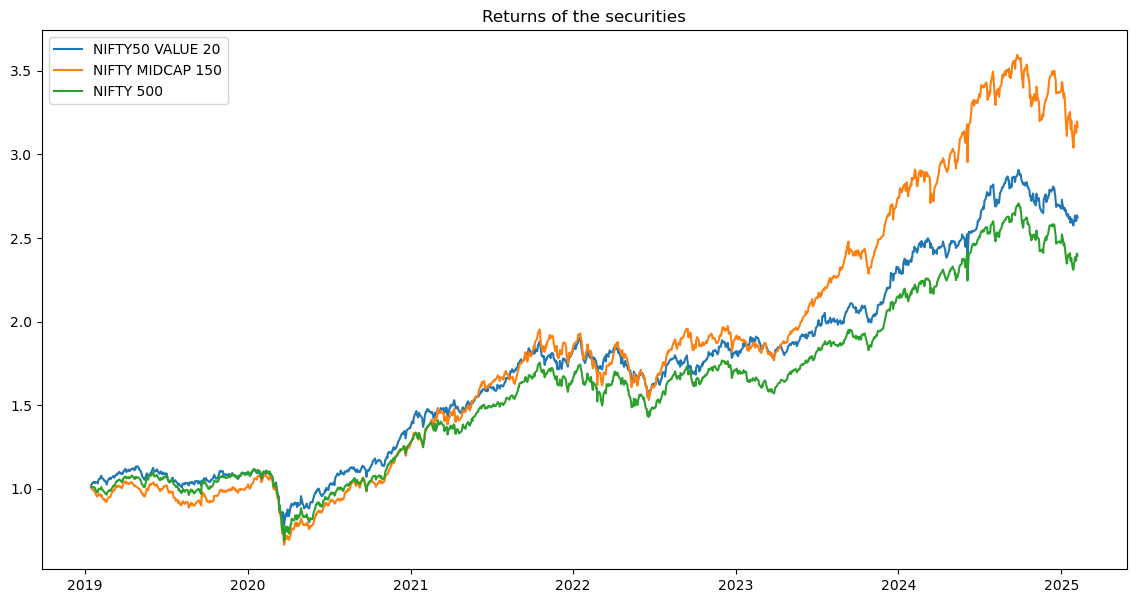

In [34]:
plt.figure(figsize=(14, 7))

temp = PORTFOLIO_INDICES.copy()
temp.append(BENCHMARK_INDEX)

for column in temp:
        plt.plot(master_data[column + '_Return'].cumprod(), label=column)
plt.legend()
plt.title('Returns of the securities')
plt.show()

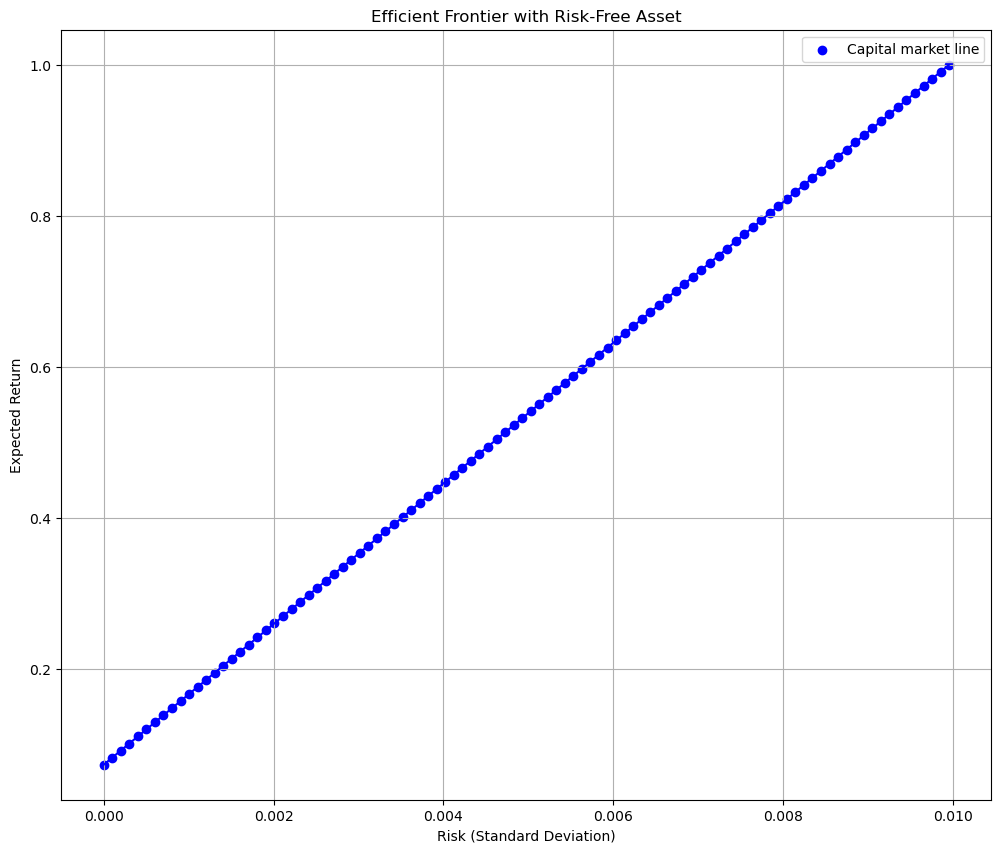

In [35]:
ACCEPTABLE_VOLATILITY = 0.15
coefficients = list(plot_capital_market_line(RISK_FREE_RETURN, master_data['NIFTY50 VALUE 20_Return'], ACCEPTABLE_VOLATILITY))

The efficient frontier curve can be a straight line when combining a risk-free asset with a single risky asset. This straight line is known as the Capital Market Line (CML). The CML represents the risk-return trade-off of a portfolio that combines a risk-free asset with a market portfolio.

This also means that in this case, the risk of the portfolio is a linear function of the risk of the risky asset, since the risk of the risk free asset is zero. Hence, irrespective of the weight of the risky asset

In [36]:
cagr_return = calculate_cagr_of_security(master_data['NIFTY50 VALUE 20'])
print(f"CAGR return of NIFTY50 VALUE 20: {round(cagr_return.item(), 2)}%")

CAGR return of NIFTY50 VALUE 20: 16.79%


Note that the CAGR return above is the return of the security from past. Not te expected return. Past returns are by no means indicative of future returns.

The expected return is a function of past returns, but also of the risk-free rate and the risk premium and inflation. The purchasing power of money decreases over time due to inflation.

The risk premium is the return that investors expect to receive for taking on additional risk. The risk premium is calculated as the difference between the expected return of the risky asset and the risk-free rate.

In [37]:
x = PORTFOLIO_INDICES.copy()
x.append('GKJFKFHK')

In [38]:
PORTFOLIO_INDICES

['NIFTY50 VALUE 20', 'NIFTY MIDCAP 150']

In [39]:
x

['NIFTY50 VALUE 20', 'NIFTY MIDCAP 150', 'GKJFKFHK']